In [62]:
%matplotlib inline
from IPython import display
from IPython.html import widgets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import fromimage
from skimage import io, segmentation, color

In [34]:
im = io.imread('meh.png')[:,:,:3]

In [57]:
im = Image.open('meh.png')

In [75]:
colors = [np.array(c) for n, c in im.getcolors() if n > 10]
colors

[array([182, 255,   0, 255]),
 array([127,  51,   0, 255]),
 array([255, 106,   0, 255]),
 array([127, 106,   0, 255]),
 array([  0,   0,   0, 255])]

In [84]:
a = fromimage(im)
b = np.zeros(a.shape[:2], dtype=np.int)

In [85]:
np.all(a == colors[0], axis=2)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [86]:
for i, c in enumerate(colors):
    b[np.all(a == c, axis=2)] = i

In [87]:
np.unique(b)

array([0, 1, 2, 3, 4])

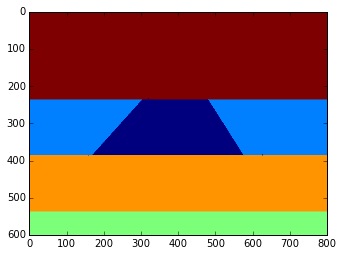

In [88]:
plt.imshow(b)

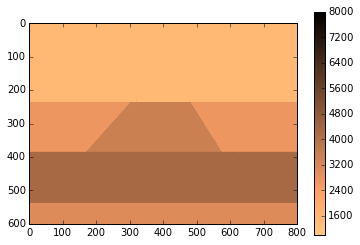

In [104]:
def make_painter_widget(labels):
    colors = np.unique(labels)
    args = dict(min=1000, max=8000, step=100, value=1000)
    sliders = dict([('V{}'.format(i + 1), widgets.FloatSlider(**args)) for i in range(len(colors))])
    model = np.empty_like(labels)
    def plot_model(**kwargs):
        for v, c in zip(kwargs, colors):
            model[labels == c] = kwargs[v]
        plt.imshow(model, cmap='copper_r', vmin=args['min'], vmax=args['max'])
        plt.colorbar()
        return model
    return widgets.interactive(plot_model, **sliders)
w = make_painter_widget(b)
w

In [105]:
w.result

array([[1500, 1500, 1500, ..., 1500, 1500, 1500],
       [1500, 1500, 1500, ..., 1500, 1500, 1500],
       [1500, 1500, 1500, ..., 1500, 1500, 1500],
       ..., 
       [3100, 3100, 3100, ..., 3100, 3100, 3100],
       [3100, 3100, 3100, ..., 3100, 3100, 3100],
       [3100, 3100, 3100, ..., 3100, 3100, 3100]])